In [2]:
import sys
sys.path.insert(1, '../')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tqdm import tqdm
from skmisc.loess import loess
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression

from agingml import continuous_retraining_test as crt

/Users/santiago/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Experiment set up
dataset = 'avocados'
min_n_train = 52
n_test = 12
n_prod = 12
n_simulations = 2
n_retrainings = 3
metric = mean_absolute_percentage_error
freq = 'W'
models = ['LGBMRegressor', 'ElasticNet', 'RandomForestRegressor', 'MLPRegressor']
model = models[0]

errors_df = pd.read_parquet(f'../results/retraining/{dataset}/retraining_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod.parquet')
d_errors_df = pd.read_parquet(f'../results/retraining/{dataset}/retraining_{dataset}_{model}_{n_simulations}_simulations_{n_prod}_prod_{freq}.parquet')

In [8]:
n_valid_models = errors_df[['simulation_id', 'is_model_valid']].drop_duplicates()['is_model_valid'].sum()
print(f"There are {n_valid_models} valid models out of {n_simulations} simulations.")

There are 2 valid models out of 2 simulations.


### Plot Error

In [9]:
d_errors_df.retraining_id.value_counts()

2    216
1    200
0    176
Name: retraining_id, dtype: int64

<Axes: xlabel='model_age', ylabel='error'>

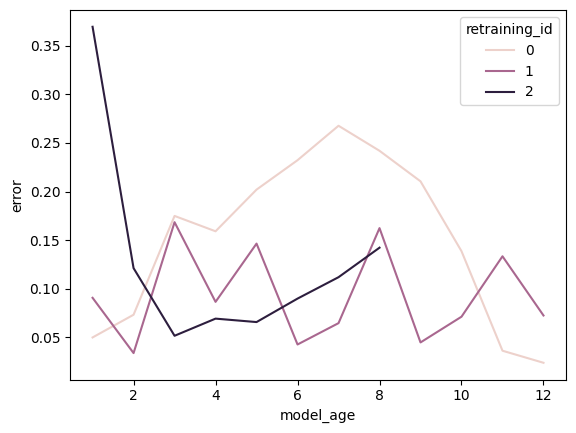

In [10]:
df = d_errors_df[d_errors_df['partition'] == 'prod']
df = df.groupby(['partition', 'retraining_id', 'model_age'])['error'].agg(lambda x: x.quantile([0.5])).rename('error').reset_index() 

sns.lineplot(data=df, x='model_age', y='error', hue='retraining_id')

In [11]:
d1 = d_errors_df[(d_errors_df['retraining_id'] == 0) & 
               (d_errors_df['partition'] == 'prod')].sort_values('model_age')
d2 = d_errors_df[(d_errors_df['retraining_id'] == 1) & 
               (d_errors_df['partition'] == 'prod')].sort_values('model_age')
d3 = d_errors_df[(d_errors_df['retraining_id'] == 2) & 
               (d_errors_df['partition'] == 'prod')].sort_values('model_age')

x1 = d1['model_age']
y1 = d1['error']

x2 = d2['model_age']
y2 = d2['error']

x3 = d3['model_age']
y3 = d3['error']

l1 = loess(x1, y1, span=0.5)
l1.fit()
pred1 = l1.predict(x1, stderror=True)
conf1 = pred1.confidence()

lowess1 = pred1.values
ll1 = conf1.lower
ul1 = conf1.upper

l2 = loess(x2, y2, span=0.5)
l2.fit()
pred2 = l2.predict(x2, stderror=True)
conf2 = pred2.confidence()

lowess2 = pred2.values
ll2 = conf2.lower
ul2 = conf2.upper

l3 = loess(x3, y3, span=0.5)
l3.fit()
pred3 = l3.predict(x3, stderror=True)
conf3 = pred3.confidence()

lowess3 = pred3.values
ll3 = conf3.lower
ul3 = conf3.upper

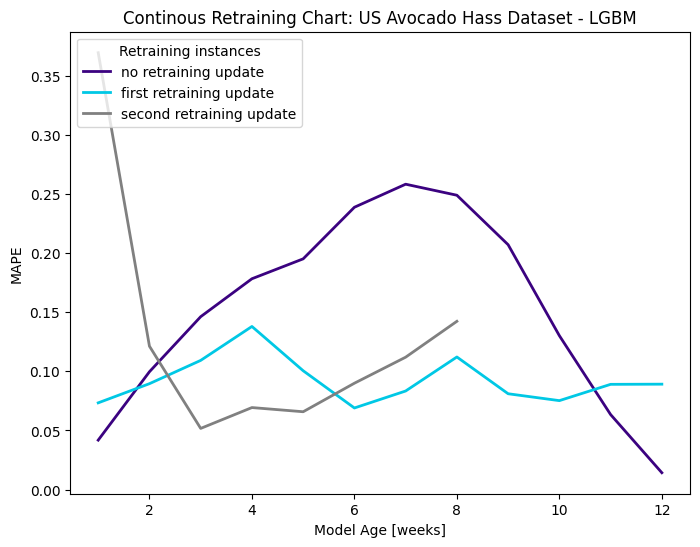

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))


plt.plot(x1, lowess1, label='no retraining update', color='#3b0280', linewidth=2.0)
# plt.fill_between(x1, ll1, ul1, color='#3b0280', alpha=.10)

plt.plot(x2, lowess2, label='first retraining update', color='#00c8e5', linewidth=2.0)
# plt.fill_between(x2, ll2, ul2, color='#00c8e5', alpha=.10)

plt.plot(x3, lowess3, label='second retraining update', color='grey', linewidth=2.0)
# plt.fill_between(x3, ll3, ul3, color='grey', alpha=.10)
plt.legend(title='Retraining instances', loc="upper left")


plt.xlabel('Model Age [weeks]')
plt.ylabel('MAPE')
plt.title('Continous Retraining Chart: US Avocado Hass Dataset - LGBM')
#fig.tight_layout()

plt.savefig('../figures/retraining_chart_calhouse_lgbm_MAPE.png', format='png')

plt.show()